<h1> RSNA 2022 Cervical Spine Fracture Detection </h1>

---

In [67]:
from IPython.display import Video, Image, HTML, display

image_path1 = "https://innerbody.imgix.net/cervical_vertebrae.png"
image_path2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Cervical_Spine_Anterior_View.png/1024px-Cervical_Spine_Anterior_View.png"
image_path3 = "http://svpow.files.wordpress.com/2013/03/wedel-and-taylor-2013-bifurcation-figure-3-human-cervical-vertebra.jpg"


HTML(f"""
    <div class="row" style="display: flex;">
            <img src={image_path1} style="height:300px; margin: auto;"> </img>
            <img src={image_path2} style="height:300px; margin: auto;"> </img>
            <img src={image_path3} style="height:300px; margin: auto;"> </img>

    </div>
    """)

---

<h1> Table of Contents </h1>

>[1 Introduction](#updateTitle=true&folderId=1EKF_3rqNbEcDMSevUKbru8-1wvuJV5Mk&scrollTo=AENFL95Y8odN)

>>[1.1 About This Project](#updateTitle=true&folderId=1EKF_3rqNbEcDMSevUKbru8-1wvuJV5Mk&scrollTo=mSxKmAy18oWJ)

>>[1.2 About the Dataset](#updateTitle=true&folderId=1EKF_3rqNbEcDMSevUKbru8-1wvuJV5Mk&scrollTo=2szP8O5B9QMP)

>>[1.3 About This Notebook](#updateTitle=true&folderId=1EKF_3rqNbEcDMSevUKbru8-1wvuJV5Mk&scrollTo=fxYFgcah9QE2)

>[2 Data Overview](#updateTitle=true&folderId=1EKF_3rqNbEcDMSevUKbru8-1wvuJV5Mk&scrollTo=hLN3QZye9P87)



---

# 1 Introduction

- Every year, around the world, between **250 000** and **500 000** people suffer a spinal cord injury (SCI).

- The majority of spinal cord injuries are due to preventable causes such as road traffic crashes, falls or violence.

- People with a spinal cord injury are **two** to **five** times more likely to die prematurely than people without a spinal cord injury, with worse survival rates in low- and middle-income countries.

- Spinal cord injury is associated with lower rates of school enrollment and economic participation, and it carries substantial individual and societal costs.

- Spinal cord injury is associated with a risk of developing secondary conditions that can be debilitating and even life-threatening—e.g. deep vein thrombosis, urinary tract infections, muscle spasms, osteoporosis, pressure ulcers, chronic pain, and respiratory complications. Acute care, rehabilitation services and ongoing health maintenance are essential for prevention and management of these conditions.

---
**Spinal Cord Scans**

Because scans rely on precision for creating sharp results, any movement can produce blurred results. You must carefully control your breathing as directed during the procedure. If you need images of a part of the body not in your thoracic region, you may be freer with your breath, but you will need to remain completely still for the scan. So it is hard to sustain reliable results by bare eye.it needs a professional Radiologists ot get such data.

## 1.1 About This Project

In this project we will look closely into how to detect cervical spine fractures
with a deep learing model to help diagnose victims faster to avoid permanent injuries or death.

Finally, we use deep learing models in order to automate cervical spine fracture detection. 

An immediate application on this is early detection of cervical spine fracture in hospitals, thus enabling proactive measurements instead of reactive. Therefore, the goal of the project is to draw statistical insights, and construct a real world application for the dataset.

## 1.2 About the Dataset

The Dataset is collected imaging data sourced from twelve sites on six continents, including approximately 3,000 CT studies. Spine radiology specialists from the ASNR and ASSR provided expert image level annotations these studies to indicate the presence, vertebral level and location of any cervical spine fractures.

### Train.csv
| Column Name | Description  |
| :------------: | :------------: |
| StudyInstanceUID  | The study ID. There is one unique study ID for each patient scan.  |
| patient_overall | One of the target columns. The patient level outcome, i.e. if any of the vertebrae are fractured  |
| C[1-7] |  The other target columns. Whether the given vertebrae is fractured. See this diagram for the real location of each vertbrae in the spine. |

------------

### Test.csv
| Column Name  | Description  |
| :------------: | :------------: |
| row_id  | The row ID. This will match the same column in the sample submission file.  |
| StudyInstanceUID  | The study ID.  |
| prediction_type  | Which one of the eight target columns needs a prediction in this row. |

-------------

### train_bounding_boxes.csv
| Column Name  | Description  |
| :------------: | :------------: |
| StudyInstanceUID  | The study ID. There is one unique study ID for each patient scan.  |
| x  | x-coordinate of bounding box bottom left corner  |
| y  | y-coordinate of bounding box bottom left corner  |
| width  | width of bounding box  |
| height  | height of bounding box  |
| slice number  | slice number of scan  |


## 1.3 About This Notebook

This Notebook is concerned with exploring the data, the cervical spine fracture, and the patterns and insights hidden inside the data. We will visualize the data in various ways in our exploration.

In [68]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
import os
from os import listdir
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
from pprint import pprint
from time import time
import itertools
from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nib
from glob import glob
import tqdm
from pydicom import dcmread
from pydicom.data import get_testdata_file
import PIL
# import gdcm


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2 Data Overview <a class="anchor" id="overview"></a>

## 2.1 Reading MetaData <a class="anchor" id="reading_metadata"></a>

In [69]:
train_data = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bobox = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_data = pd.read_csv("../input/rsna-2022-cervical-spine-fracture-detection/test.csv")

In [70]:
train_data

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0      1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1     1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2     1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3     1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4      1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0
...                         ...              ...  ..  ..  ..  ..  ..  ..  ..
2014  1.2.826.0.1.3680043.21684                1   0   1   0   0   0   1   1
2015   1.2.826.0.1.3680043.4786                1   0   0   0   0   0   0   1
2016  1.2.826.0.1.3680043.14341                0   0   0   0   0   0   0   0
2017  1.2.826.0.1.3680043.12053                0   0   0   0   0   0   0   0
2018  1.2.826.0.1.3680043.18786                1   0   0   0   0   0   0   1

[2019 rows x 9 columns]

In [71]:
train_bobox

StudyInstanceUID          x          y     width    height  \
0     1.2.826.0.1.3680043.10051  219.27715  216.71419  17.30440  20.38517   
1     1.2.826.0.1.3680043.10051  221.56460  216.71419  17.87844  25.24362   
2     1.2.826.0.1.3680043.10051  216.82151  221.62546  27.00959  26.37454   
3     1.2.826.0.1.3680043.10051  214.49455  215.48637  27.92726  37.51363   
4     1.2.826.0.1.3680043.10051  214.00000  215.48637  27.00000  43.51363   
...                         ...        ...        ...       ...       ...   
7212   1.2.826.0.1.3680043.9940  297.23186  115.53983  85.18228  66.52623   
7213   1.2.826.0.1.3680043.9940  298.00000  117.00000  86.00000  61.00000   
7214   1.2.826.0.1.3680043.9940  298.00000  119.00000  87.00000  58.00000   
7215   1.2.826.0.1.3680043.9940  299.00000  120.00000  89.00000  56.00000   
7216   1.2.826.0.1.3680043.9940  299.04425  121.88319  89.71326  53.46549   

      slice_number  
0              133  
1              134  
2              135  
3              136  
4              137  
...            ...  
7212           140  
7213           141  
7214           142  
7215           143  
7216           144  

[7217 rows x 6 columns]

In [72]:
print(train_data.info(), end='\n\n')
print(test_data.info(), end='\n\n')
print(train_bobox.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   StudyInstanceUID  2019 non-null   object
 1   patient_overall   2019 non-null   int64 
 2   C1                2019 non-null   int64 
 3   C2                2019 non-null   int64 
 4   C3                2019 non-null   int64 
 5   C4                2019 non-null   int64 
 6   C5                2019 non-null   int64 
 7   C6                2019 non-null   int64 
 8   C7                2019 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 142.1+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   row_id            3 non-null      object
 1   StudyInstanceUID  3 non-null      object
 2   prediction_type   3 non-null      object


## 2.2 Reading Example Scan <a class="anchor" id="reading_example_scan"></a>

In [73]:
train_data['StudyInstanceUID'][0]

'1.2.826.0.1.3680043.6200'

In [74]:
example = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001/101.dcm"
dcm_example = pydicom.dcmread(example)
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10001.1.101
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10001.1.101
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '175846.512627'
(0010, 0010) Patient's Name                      PN: '10001'
(0010, 0020) Patient ID                          LO: '10001'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

## 2.3 Visualizing Scan <a class="anchor" id="visualizing_scan"></a>

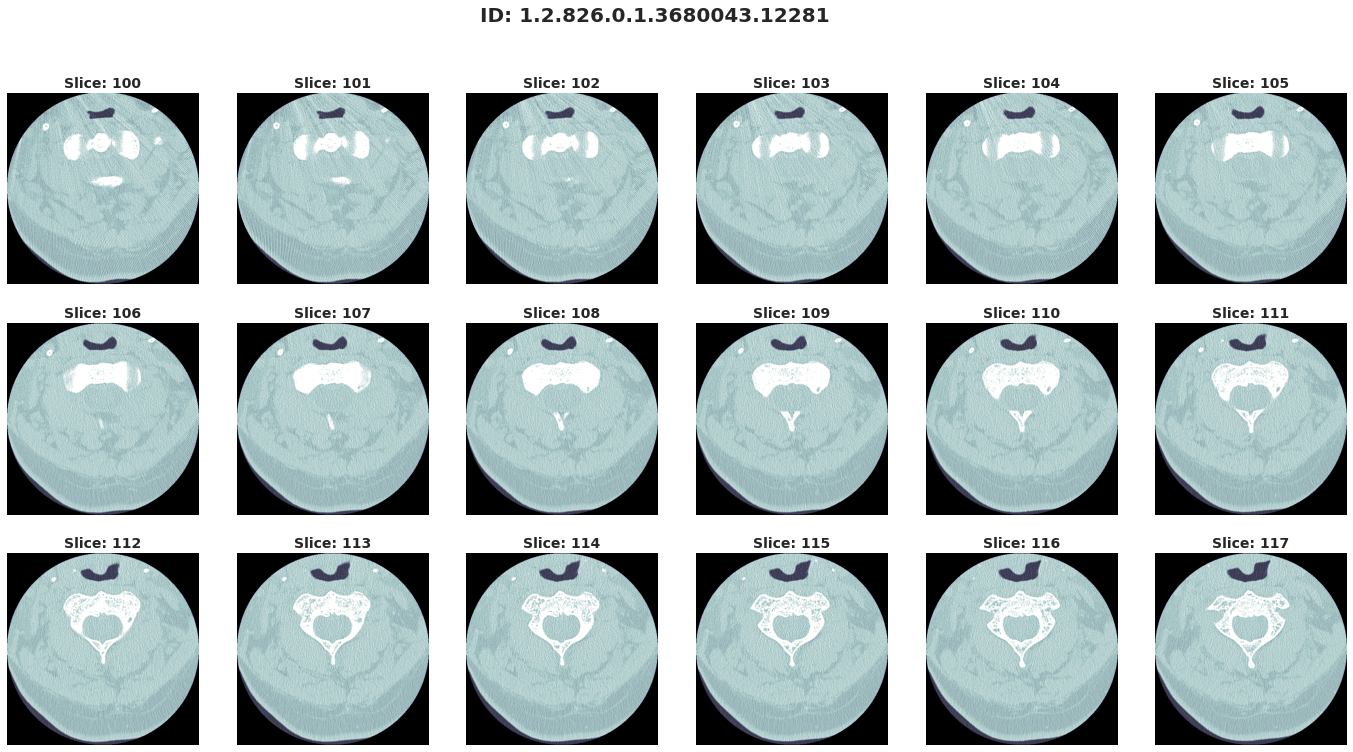

In [75]:
base_path = "../input/rsna-2022-cervical-spine-fracture-detection"
patient_id = '1.2.826.0.1.3680043.12281'
dcm_paths = glob(f"{base_path}/train_images/{patient_id}/*")
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]
dcm_paths.sort(key=natural_keys)

# Get images
files = [pydicom.dcmread(path) for path in dcm_paths]
images = [apply_voi_lut(file.pixel_array, file) for file in files]

# Plot images
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

start = 100
for i in range(start,start+18):
    img = images[i]
    file = files[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(img, cmap="bone")
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

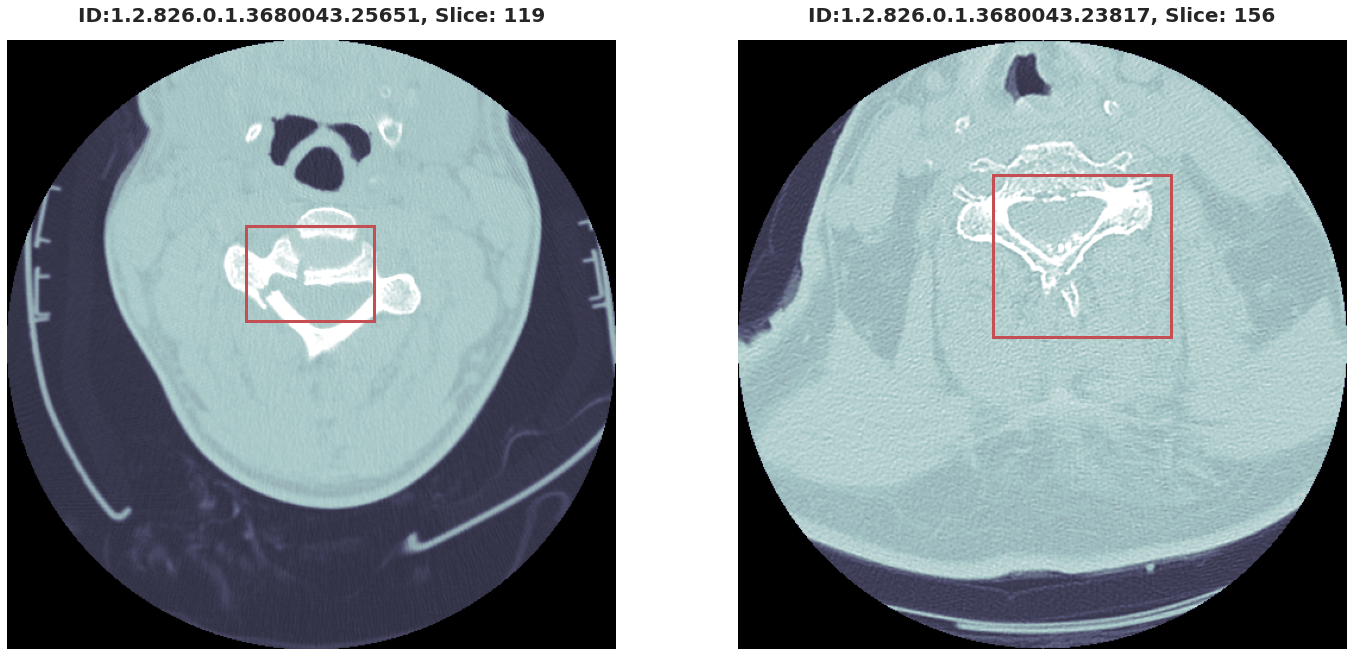

In [76]:
def plot_fracture(slice_num,bbox_id,ax_id1):
    file = pydicom.dcmread(f"{base_path}/train_images/{bbox_id}/{slice_num}.dcm")
    img = apply_voi_lut(file.pixel_array, file)
    info = train_bobox[(train_bobox['StudyInstanceUID']==bbox_id)&(train_bobox['slice_number']==slice_num)]
    rect = patches.Rectangle((float(info.x), float(info.y)), float(info.width), float(info.height), linewidth=3, edgecolor='r', facecolor='none')

    axes[ax_id1].imshow(img, cmap="bone")
    axes[ax_id1].add_patch(rect)
    axes[ax_id1].set_title(f"ID:{bbox_id}, Slice: {slice_num}", fontsize=20, weight='bold',y=1.02)
    axes[ax_id1].axis('off')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24,24))
plot_fracture(119,'1.2.826.0.1.3680043.25651',0)
plot_fracture(156,'1.2.826.0.1.3680043.23817',1)

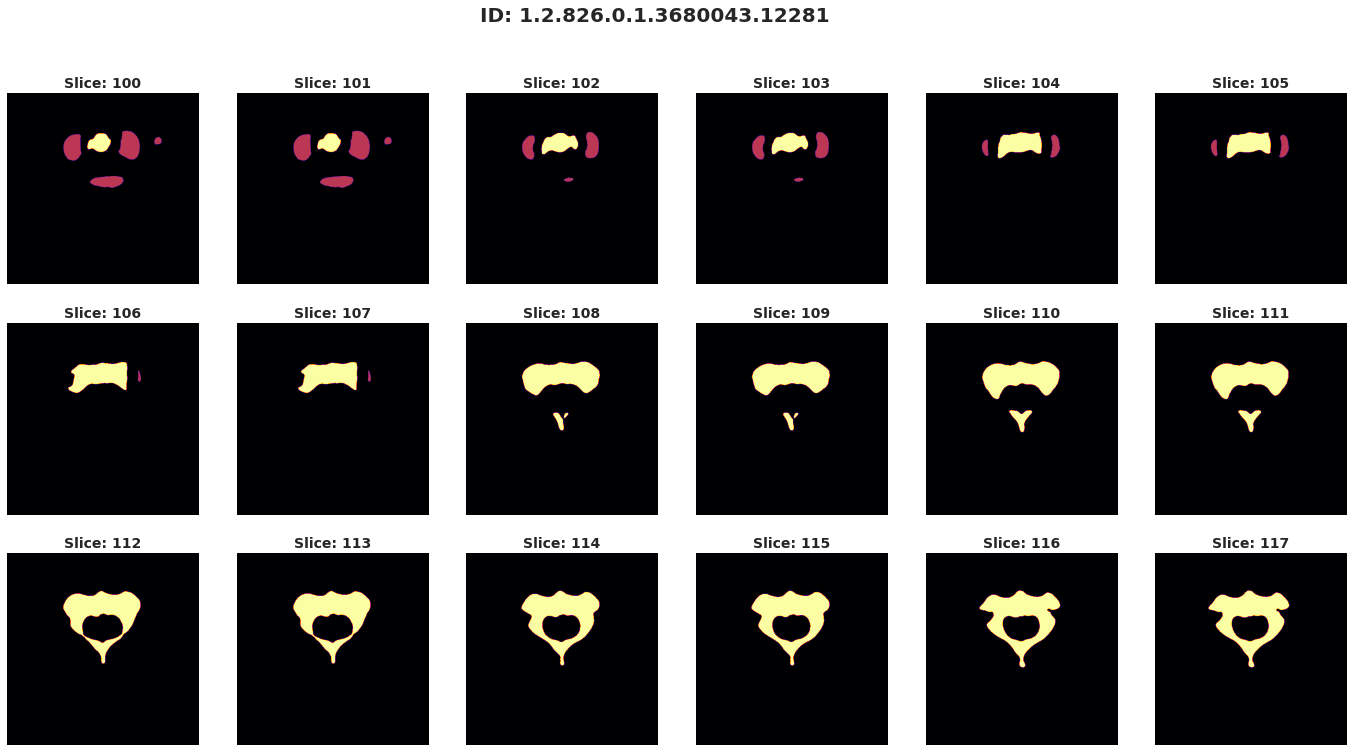

In [77]:

ex_path2 = f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{patient_id}.nii"
nii_example = nib.load(ex_path2)

# Convert to numpy array
seg = nii_example.get_fdata()
seg = seg[:, ::-1, ::-1].transpose(2, 1, 0)

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: {patient_id}', weight="bold", size=20)

for i in range(start,start+18):
    mask = seg[i]
    slice_no = i

    # Plot the image
    x = (i-start) // 6
    y = (i-start) % 6

    axes[x, y].imshow(mask, cmap='inferno')
    axes[x, y].set_title(f"Slice: {slice_no}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [78]:
def show_images(folder_path, num=8, cmap='bone'):
    """This function take a folder path and show some images"""
    sample = glob(folder_path + '/*')
    files = [pydicom.dcmread(path) for path in sample]
    images = [apply_voi_lut(file.pixel_array, file)for file in files]
    title = 'Patient ID ' + str(folder_path.split('/')[-1])
    plt.figure(figsize=(20, 20))
    for i in range(num):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(title, fontsize=10)
        plt.axis('off')

In [79]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    """
    img = pydicom.dcmread(path)
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

In [80]:
img, img_dcm = load_dicom('../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10032/102.dcm')

In [81]:
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [82]:
img_dcm

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10032.1.102
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10032.1.102
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '184453.788995'
(0010, 0010) Patient's Name                      PN: '10032'
(0010, 0020) Patient ID                          LO: '10032'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

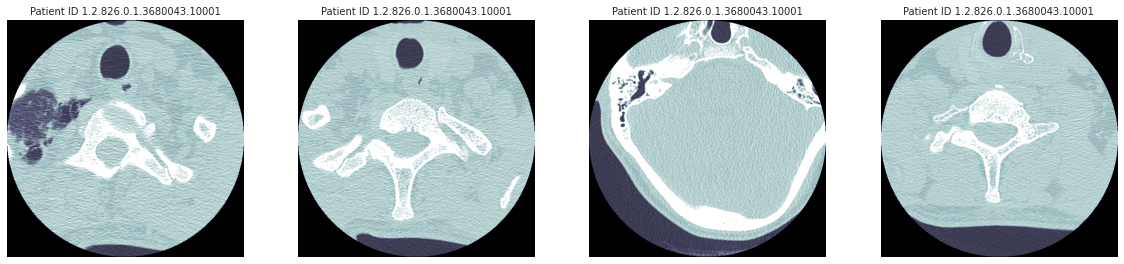

In [83]:
show_images('../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001', num=4)

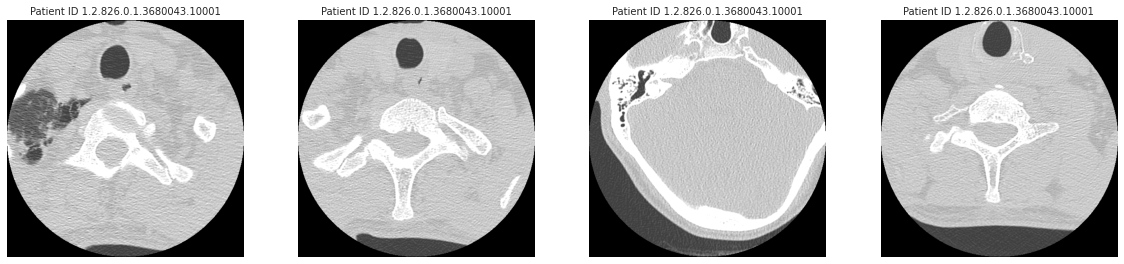

In [84]:
show_images('../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001', cmap='gray', num=4)

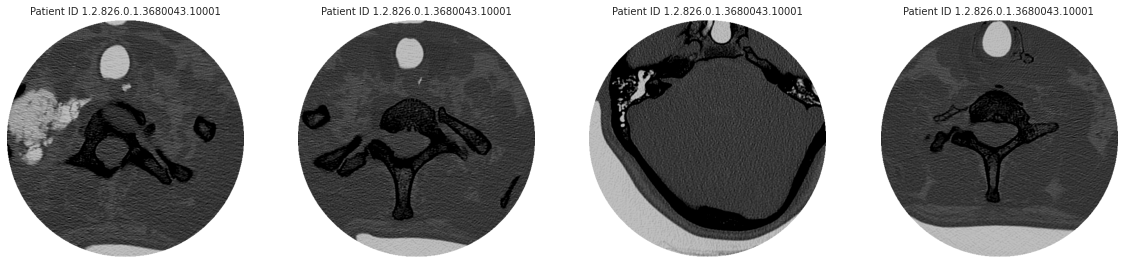

In [85]:
show_images('../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10001', cmap='binary', num=4)

# 3 EDA <a class="anchor" id="eda"></a>

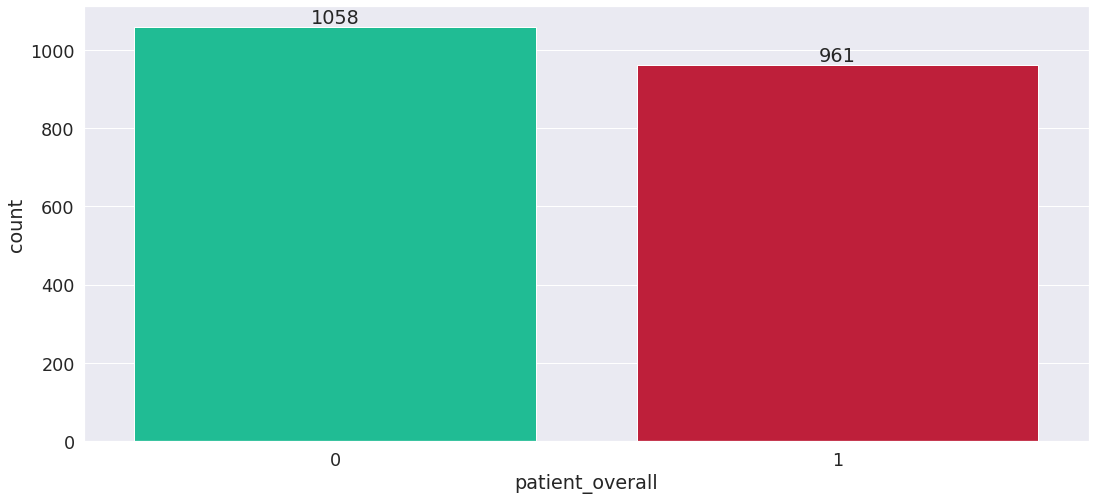

In [86]:
plt.figure(figsize=(18,8))
ax = sns.countplot(x="patient_overall",data=train_data, palette=["#06d6a0", "#d90429"])
for container in ax.containers:
    ax.bar_label(container)

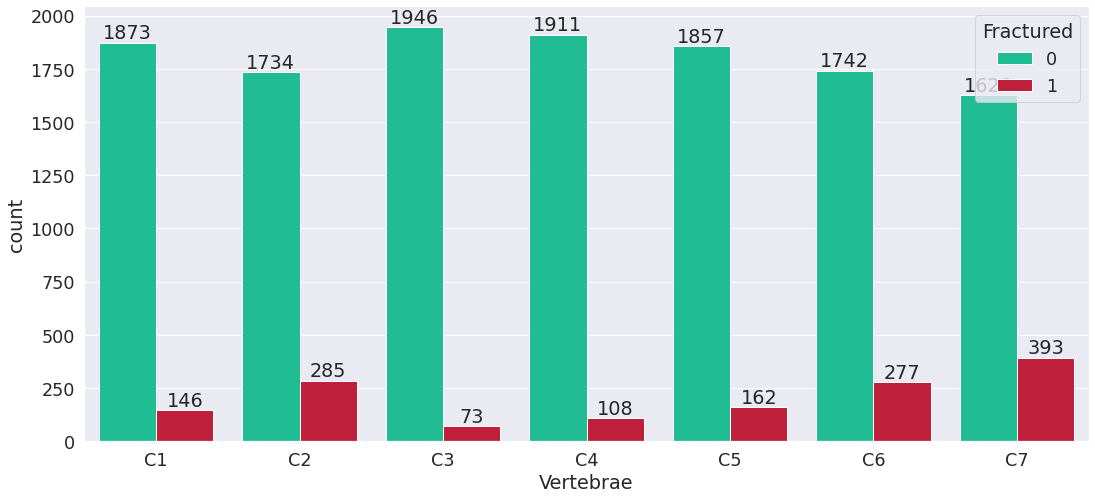

In [87]:
plt.figure(figsize=(18,8))
train_ver_f = pd.melt(train_data, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")
ax2 = sns.countplot(data=train_ver_f, x='Vertebrae', hue='Fractured', palette=["#06d6a0", "#d90429"])
for container in ax2.containers:
    ax2.bar_label(container)

Text(0.5, 1.0, 'Correlations')

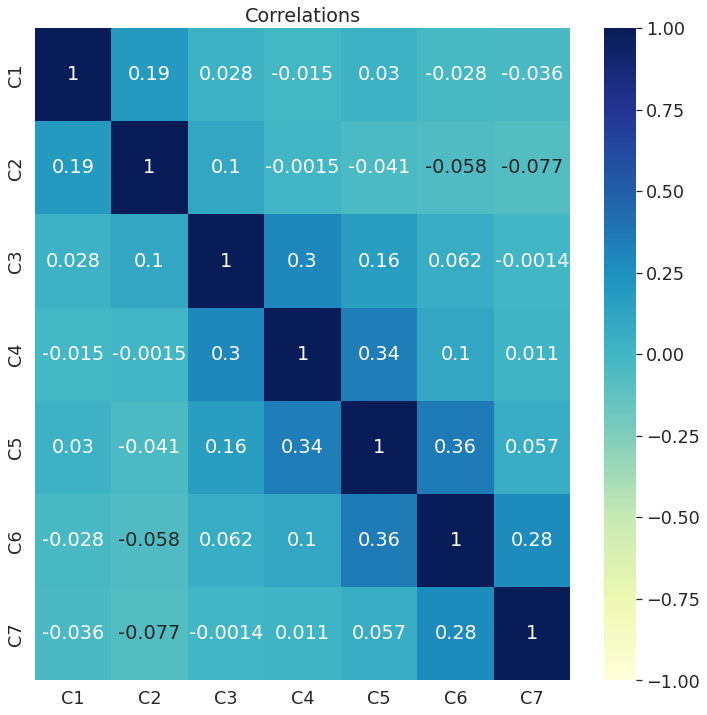

In [88]:
plt.figure(figsize=(12,12))
sns.heatmap(train_data[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='YlGnBu', vmin=-1, vmax=1, annot = True )
plt.title('Correlations')

<AxesSubplot:>

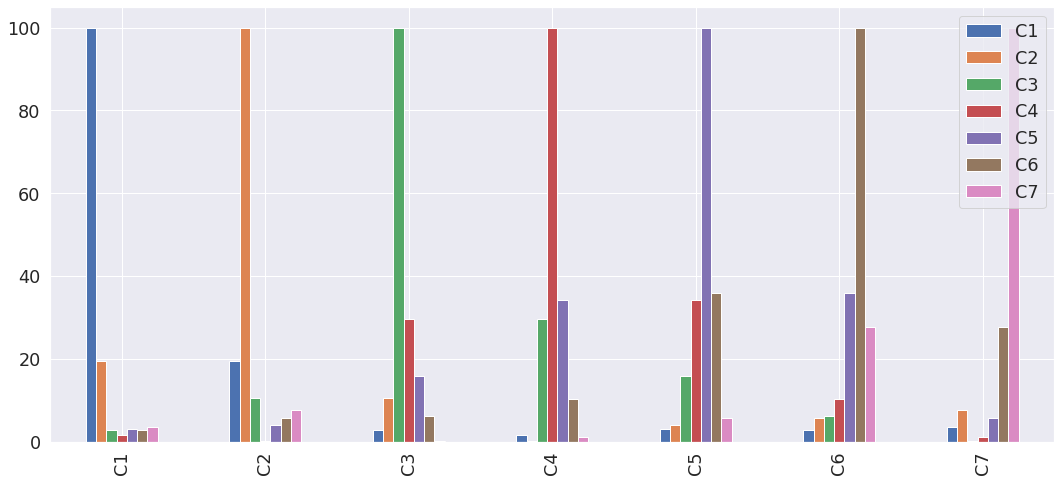

In [89]:
pd.DataFrame(abs(train_data[['C1','C2','C3','C4','C5','C6','C7']].corr()*100)).plot.bar(figsize = (18,8))

Text(0.5, 1.0, 'Correlations')

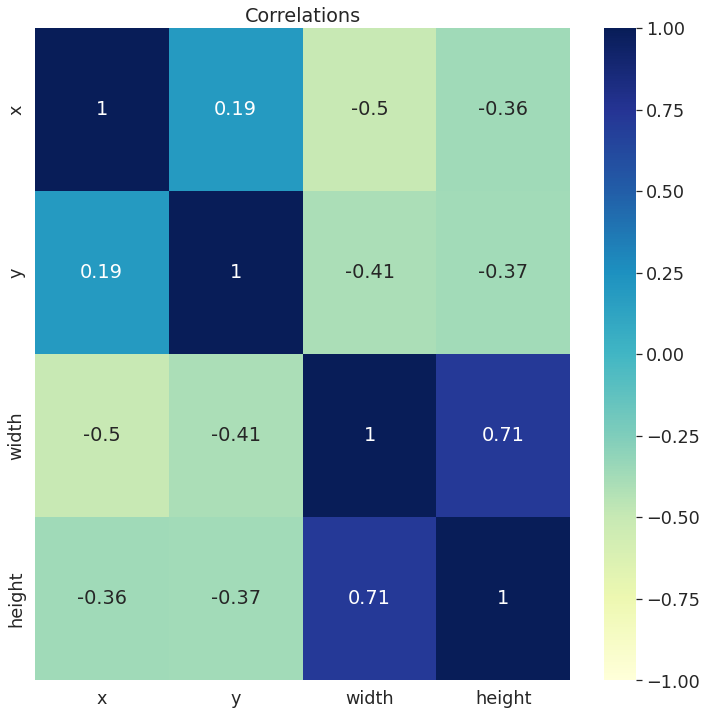

In [90]:
plt.figure(figsize=(12,12))
sns.heatmap(train_bobox[['x','y','width','height']].corr(), cmap='YlGnBu', vmin=-1, vmax=1, annot = True )
plt.title('Correlations')

<AxesSubplot:>

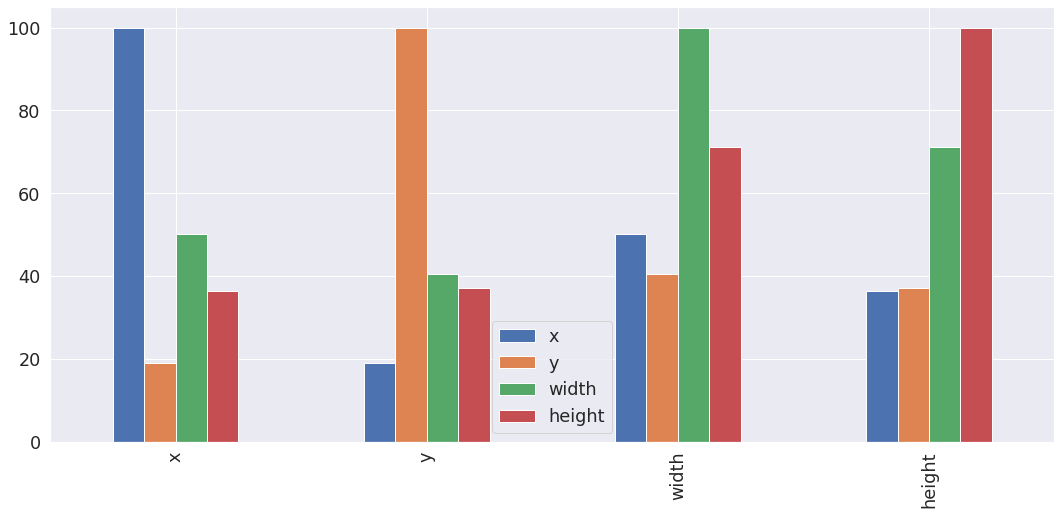

In [91]:
pd.DataFrame(abs(train_bobox[['x','y','width','height']].corr()*100)).plot.bar(figsize = (18,8))

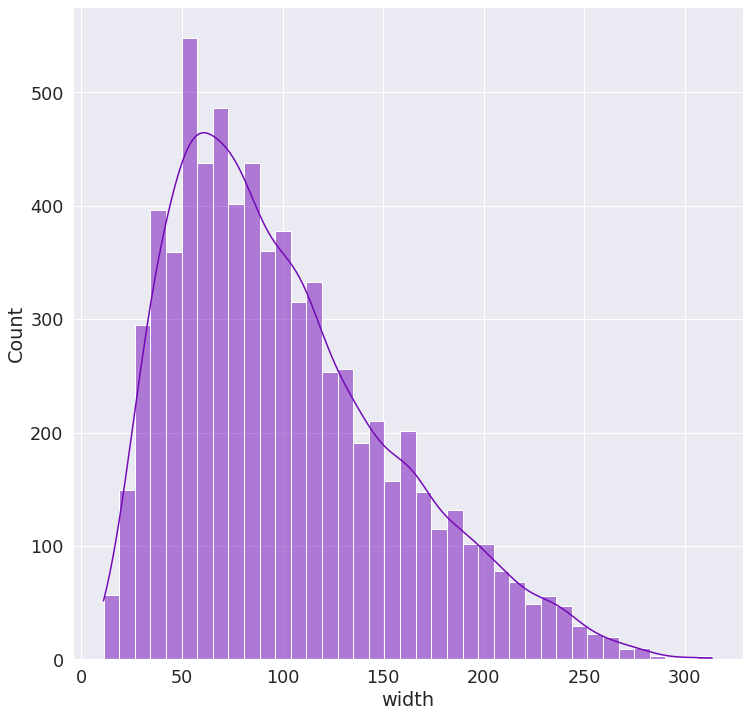

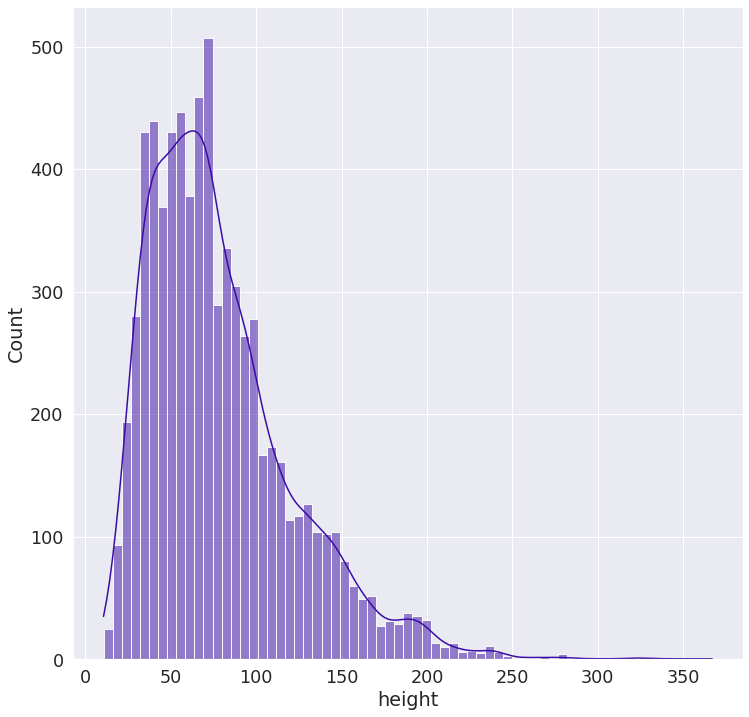

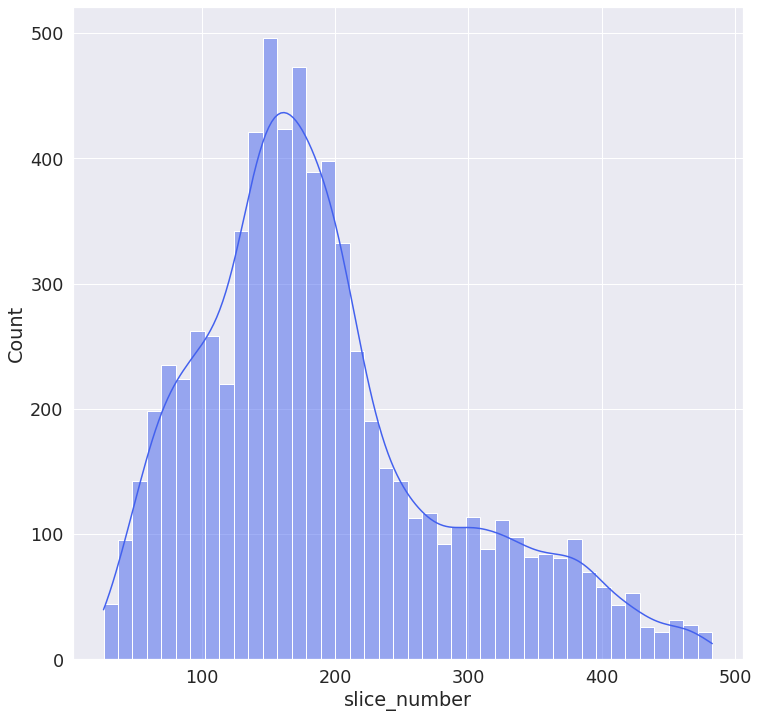

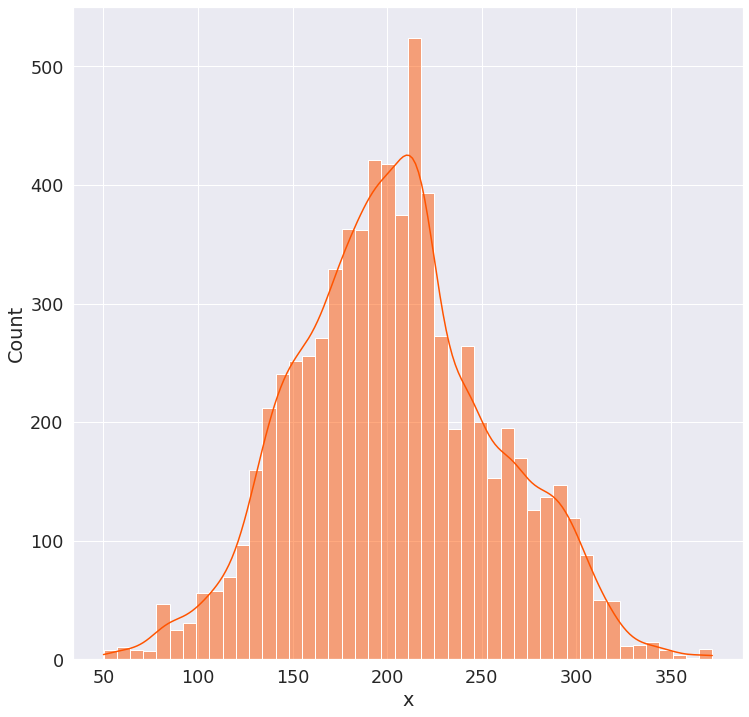

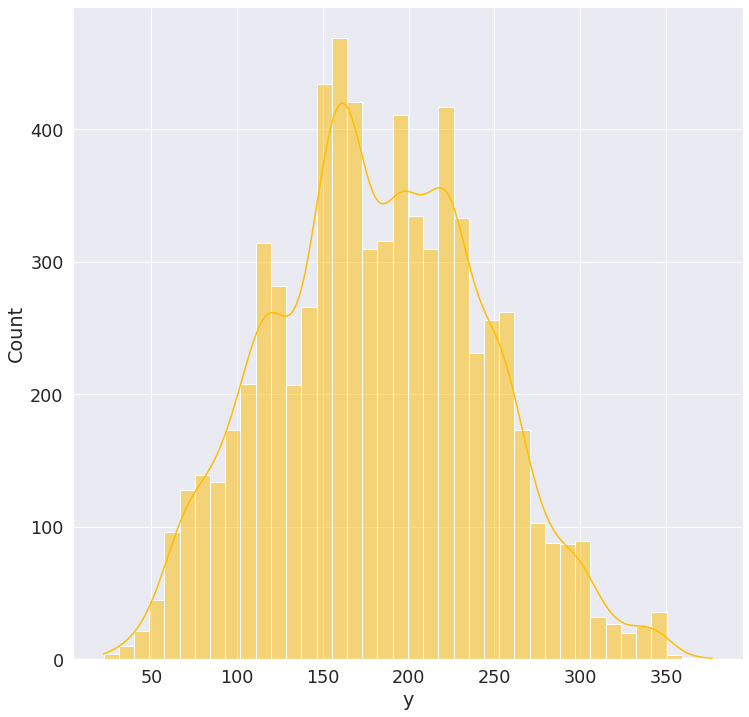

In [92]:
plt.figure(figsize=(12,12))
sns.histplot(train_bobox["width"],kde=True, color="#7209b7")
plt.show()
plt.figure(figsize=(12,12))
sns.histplot(train_bobox["height"], kde = True, color="#3a0ca3")
plt.show()
plt.figure(figsize=(12,12))
sns.histplot(train_bobox["slice_number"], kde=True, color="#4361ee")
plt.show()
plt.figure(figsize=(12,12))
sns.histplot(train_bobox["x"], kde=True, color="#ff5400")
plt.show()
plt.figure(figsize=(12,12))
sns.histplot(train_bobox["y"], kde=True, color="#ffbd00")
plt.show()

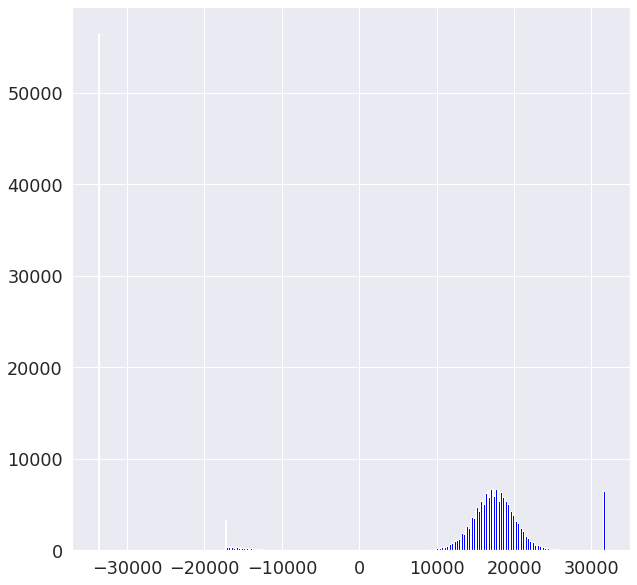

In [93]:
plt.figure(figsize=(10,10))
plt.hist(images[0].ravel(), bins=300, color="blue");

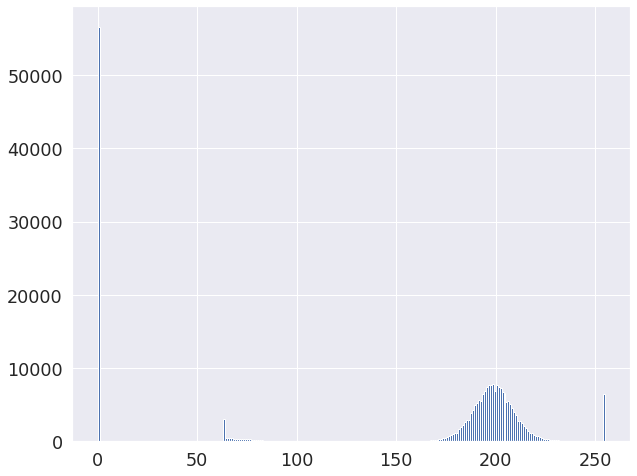

In [94]:
plt.figure(figsize=(10,8))
data = (images[0] - np.min(images[0]))
data = data / np.max(data)
data = data*255;
plt.hist(data.ravel(), bins=255);

# Preprocessoing

In [95]:
train_main_path = '../input/rsna-2022-cervical-spine-fracture-detection/train_images/'
all_df = pd.merge(train_data, train_bobox, 'inner', on='StudyInstanceUID')
values_from_df = all_df[all_df['StudyInstanceUID']== '1.2.826.0.1.3680043.21561']['slice_number'].values
values_from_path = os.listdir(train_main_path+'1.2.826.0.1.3680043.21561')
values_from_path = [int(i.split('.')[0]) for i in values_from_path]
result = list(set(values_from_path).intersection(set(values_from_df)))

In [96]:
def add_colum():
    seg = glob('../input/rsna-2022-cervical-spine-fracture-detection/segmentations/*') 
    for i in range(len(all_df)):
        full_path = train_main_path+ all_df.loc[i,'StudyInstanceUID']+ '/'+str(all_df.loc[i,'slice_number'])+'.dcm'
        
        if full_path in (glob('../input/rsna-2022-cervical-spine-fracture-detection/train_images/'+all_df.loc[i,'StudyInstanceUID']+'/*')):
            all_df.loc[i,'img_path'] = full_path
            
        else:
            all_df.loc[i,'img_path'] = np.nan
            
        
        seg_path = '../input/rsna-2022-cervical-spine-fracture-detection/segmentations/'+ all_df.loc[i,'StudyInstanceUID']+'.nii'
        if seg_path in (seg):
            all_df.loc[i, 'seg_path'] = seg_path
        
        else:
            all_df.loc[i, 'seg_path'] = np.nan
add_colum()
all_df.head()

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  \
0  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
1  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
3  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
4  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   

       x         y      width    height  slice_number  \
0  148.0  85.00000  157.00000  71.00000           100   
1  144.0  84.00000  162.00000  73.00000           101   
2  141.0  79.14078  167.00000  80.85922           102   
3  137.0  80.00000  172.00000  82.00000           103   
4  133.0  78.00000  179.19739  86.00000           104   

                                            img_path seg_path  
0  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
1  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
2  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
3  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
4  ../input/rsna-2022-cervical-spine-fracture-det...      NaN

In [97]:
len(set(['.'.join(i.split('.')[:-1]) for i in os.listdir('../input/rsna-2022-cervical-spine-fracture-detection/segmentations')]))
len(set(all_df['StudyInstanceUID']))
len(set(['.'.join(i.split('.')[:-1]) for i in os.listdir('../input/rsna-2022-cervical-spine-fracture-detection/segmentations')]).intersection(set(all_df['StudyInstanceUID'])))
set(['.'.join(i.split('.')[:-1]) for i in os.listdir('../input/rsna-2022-cervical-spine-fracture-detection/segmentations')]).intersection(set(all_df['StudyInstanceUID']))
all_df

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  \
0     1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
1     1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
2     1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
3     1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
4     1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
...                         ...              ...  ..  ..  ..  ..  ..  ..  ..   
7212  1.2.826.0.1.3680043.21684                1   0   1   0   0   0   1   1   
7213  1.2.826.0.1.3680043.21684                1   0   1   0   0   0   1   1   
7214  1.2.826.0.1.3680043.21684                1   0   1   0   0   0   1   1   
7215  1.2.826.0.1.3680043.21684                1   0   1   0   0   0   1   1   
7216  1.2.826.0.1.3680043.21684                1   0   1   0   0   0   1   1   

          x          y      width    height  slice_number  \
0     148.0   85.00000  157.00000  71.00000           100   
1     144.0   84.00000  162.00000  73.00000           101   
2     141.0   79.14078  167.00000  80.85922           102   
3     137.0   80.00000  172.00000  82.00000           103   
4     133.0   78.00000  179.19739  86.00000           104   
...     ...        ...        ...       ...           ...   
7212  213.0  265.00000   31.00000  72.00000           200   
7213  213.0  265.00000   31.00000  73.00000           201   
7214  213.0  265.00000   31.00000  73.00000           202   
7215  214.0  264.00000   31.00000  74.00000           203   
7216  214.0  264.00000   31.00000  75.00000           204   

                                               img_path seg_path  
0     ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
1     ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
2     ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
3     ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
4     ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
...                                                 ...      ...  
7212  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
7213  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
7214  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
7215  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
7216  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  

[7217 rows x 16 columns]

In [ ]:
all_df.to_csv("all_df.csv", )

In [98]:
unique_ids = list(train_bobox["StudyInstanceUID"].unique())
labels = []
all_dcm_files = []
dir = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/"

for uid in unique_ids:
    patient_scans_with_fractures = train_bobox[train_bobox['StudyInstanceUID'] == uid]
    scans_with_fractures = list(patient_scans_with_fractures['slice_number'])
    files = []
    scan_directory = dir + uid
    neg_scans = []
    count = 0
    for file in os.listdir(scan_directory):
        if file.endswith('.dcm'):
            # the list of all dicom files in the patient folder
            files.append(os.path.join(scan_directory, file))
            # get the scan number and check if it is in the list of scans with fractures
            scan_number = int(file.split('.')[0])
            # if it is in the list, append a 1 to the list of labels otherwise append a 1
            if scan_number in scans_with_fractures:
                labels.append(1)
                all_dcm_files.append(os.path.join(scan_directory, file))
                count += 1
            else:
                # labels.append(0)   
                neg_scans.append(os.path.join(scan_directory, file))# file shoul rep the full path
    sublist = random.sample(neg_scans, k = count)
    all_dcm_files.extend(sublist)
    labels.extend([0] * count)
len(all_dcm_files), len(labels)

(14434, 14434)

In [99]:
pydicom.dcmread(glob(glob(train_main_path+'/*')[10]+'/*')[10])

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.12655.1.97
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.12655.1.97
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183928.367568'
(0010, 0010) Patient's Name                      PN: '12655'
(0010, 0020) Patient ID                          LO: '12655'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0

In [100]:
len(os.listdir('../input/rsna-csfd-256x256-jpg-dataset/train_images'))*100/2019

100.0

> We now have 85% from our data to work on

In [101]:
print(len(set(os.listdir('../input/rsna-csfd-256x256-jpg-dataset/train_images/')).intersection(set(all_df['StudyInstanceUID']))))
print(len(set(train_data['StudyInstanceUID']).intersection(set(all_df['StudyInstanceUID']))))
print(len(set(train_bobox['StudyInstanceUID']).intersection(set(all_df['StudyInstanceUID']))))

235
235
235


In [102]:
glob('../input/rsna-csfd-256x256-jpg-dataset/train_images/*')[0]

'../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.17625'

In [103]:
slice_num = train_bobox[train_bobox['StudyInstanceUID']=='1.2.826.0.1.3680043.1981']['slice_number'].values
real_num = os.listdir('../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.1981')
real_num = [int(i.split('.')[0]) for i in real_num]

print(f'Slice number for specific ID : {len(slice_num)}')
print(f'Real number for specific ID : {len(real_num)}')

print(f'The length of intersection between them : {len(set(slice_num).intersection(set(real_num)))}')

Slice number for specific ID : 14
Real number for specific ID : 347
The length of intersection between them : 14


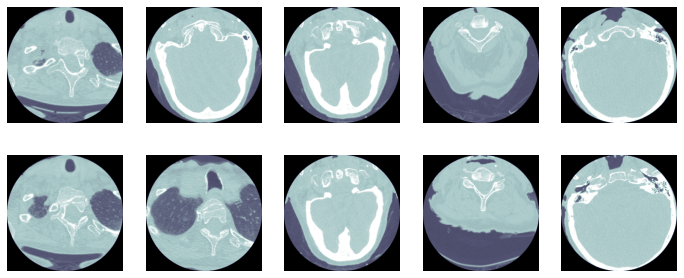

In [104]:
# Show sample images from the same ID
imgs = glob(glob('../input/rsna-csfd-256x256-jpg-dataset/train_images/*')[0]+'/*')[:10]

plt.figure(figsize=(12,5))
for i in range(len(imgs)):
    plt.subplot(2,5,i+1)
    plt.imshow(plt.imread(imgs[i]), cmap='bone')
    plt.axis('off')

In [105]:
all_df[['C1', 'C2', 'C3', 'C4', 'C5','C6', 'C7']].tail()

C1  C2  C3  C4  C5  C6  C7
7212   0   1   0   0   0   1   1
7213   0   1   0   0   0   1   1
7214   0   1   0   0   0   1   1
7215   0   1   0   0   0   1   1
7216   0   1   0   0   0   1   1

In [106]:
all_df.head()

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7  \
0  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
1  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
3  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   
4  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0   

       x         y      width    height  slice_number  \
0  148.0  85.00000  157.00000  71.00000           100   
1  144.0  84.00000  162.00000  73.00000           101   
2  141.0  79.14078  167.00000  80.85922           102   
3  137.0  80.00000  172.00000  82.00000           103   
4  133.0  78.00000  179.19739  86.00000           104   

                                            img_path seg_path  
0  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
1  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
2  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
3  ../input/rsna-2022-cervical-spine-fracture-det...      NaN  
4  ../input/rsna-2022-cervical-spine-fracture-det...      NaN

In [107]:
train_data.set_index('StudyInstanceUID', inplace=True)

In [108]:
new_train_data = train_data.loc[os.listdir('../input/rsna-csfd-256x256-jpg-dataset/train_images/'),:].reset_index()
new_train_data

StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0     1.2.826.0.1.3680043.17625                1   0   1   0   0   0   0   0
1      1.2.826.0.1.3680043.3850                0   0   0   0   0   0   0   0
2      1.2.826.0.1.3680043.2286                1   0   0   0   0   0   1   0
3     1.2.826.0.1.3680043.14435                0   0   0   0   0   0   0   0
4      1.2.826.0.1.3680043.3442                0   0   0   0   0   0   0   0
...                         ...              ...  ..  ..  ..  ..  ..  ..  ..
2014  1.2.826.0.1.3680043.21459                0   0   0   0   0   0   0   0
2015  1.2.826.0.1.3680043.20723                1   0   0   0   0   0   0   1
2016  1.2.826.0.1.3680043.16770                0   0   0   0   0   0   0   0
2017  1.2.826.0.1.3680043.19410                0   0   0   0   0   0   0   0
2018  1.2.826.0.1.3680043.30741                0   0   0   0   0   0   0   0

[2019 rows x 9 columns]

In [109]:
np.repeat(new_train_data[['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5','C6', 'C7']].iloc[10].values, 5)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [110]:
rep = list(np.tile(new_train_data[['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5','C6', 'C7']].iloc[10].values, (8, 1)))

In [111]:
ids = list(new_train_data['StudyInstanceUID'])
final_paths = []
final_labels = []
for i in range(len(ids)):
    p = os.path.join('../input/rsna-csfd-256x256-jpg-dataset/train_images/',str(ids[i]))
    paths = glob(p+'/*')
    
    final_paths.extend(paths)
    final_labels.extend(list(np.tile(new_train_data[['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5','C6', 'C7']].iloc[i].values, (len(paths), 1))))

In [112]:
len(final_paths), len(final_labels)

(711601, 711601)

In [113]:
final_df = pd.DataFrame({
    'imgs_paths':final_paths,
    })

In [114]:
final_df[['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5','C6', 'C7']] = final_labels

In [115]:
final_df.head()

imgs_paths  patient_overall  C1  C2  \
0  ../input/rsna-csfd-256x256-jpg-dataset/train_i...                1   0   1   
1  ../input/rsna-csfd-256x256-jpg-dataset/train_i...                1   0   1   
2  ../input/rsna-csfd-256x256-jpg-dataset/train_i...                1   0   1   
3  ../input/rsna-csfd-256x256-jpg-dataset/train_i...                1   0   1   
4  ../input/rsna-csfd-256x256-jpg-dataset/train_i...                1   0   1   

   C3  C4  C5  C6  C7  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0

In [116]:
final_df.shape

(711601, 9)

In [117]:
final_train, final_valid = train_test_split(final_df, test_size=0.2, random_state=42, stratify=final_df[['patient_overall','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']])

In [118]:
print(f'Training shape : {len(final_train)} rows')
print(f'Validation shape : {len(final_valid)} rows')

Training shape : 569280 rows
Validation shape : 142321 rows


In [119]:
final_train.columns[1:8]

Index(['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'], dtype='object')

In [121]:
image_gen = ImageDataGenerator(rescale=1/255.0)


train_data_gen = image_gen.flow_from_dataframe(dataframe=final_train,
                                               x_col='imgs_paths',
                                               y_col= list(final_train.columns[1:8]),
                                               shuffle=True,
                                               target_size=(256, 256),
                                               batch_size=32,
                                               class_mode='raw',
                                                validate_filenames=False)

val_data_gen = image_gen.flow_from_dataframe(dataframe=final_valid,
                                               x_col='imgs_paths',
                                               y_col= list(final_valid.columns[1:8]),
                                               shuffle=True,
                                               target_size=(256, 256),
                                               batch_size=32,
                                               class_mode='raw',
                                              validate_filenames=False)

Found 569280 non-validated image filenames.
Found 142321 non-validated image filenames.


In [122]:
from keras.applications.densenet import DenseNet121
from keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras


densenet = DenseNet121(
    weights=None,
    input_tensor=None,
    include_top=False,
    input_shape = (256, 256,3),
    classes=1
)

output = densenet.layers[-1].output
output = keras.layers.Flatten()(output)
output = keras.layers.Dense(1,activation='sigmoid')(output)

densenet = Model(densenet.input, output)

densenet.summary()

2022-11-13 12:24:00.384691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:24:00.386127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:24:00.741088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:24:00.742066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:24:00.742882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [123]:
densenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae', 'accuracy'])
callback = keras.callbacks.EarlyStopping(patience=4, mode='min', monitor='val_loss')

In [124]:
history = densenet.fit_generator(train_data_gen, epochs=1, callbacks=[callback], validation_data=val_data_gen)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-13 12:26:45.906742: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-13 12:26:58.465117: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


17790/17790 [==============================] - 9449s 530ms/step - loss: 55.5363 - mae: 0.2006 - accuracy: 0.4825 - val_loss: 44.4265 - val_mae: 0.2319 - val_accuracy: 0.0816


In [125]:
densenet.save('densenet.h5')

In [2]:
from tensorflow import keras
model = keras.models.load_model('../input/trained-fracturedetector-model/fracturedetector_model.h5')

2022-11-14 16:32:48.109275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:32:48.110238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:32:48.376605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:32:48.377429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 16:32:48.378183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [3]:
model